## 协和4+4舆情风控模拟项目 ##

本项目为模拟案例，旨在展示内容安全与舆情应对能力，聚焦**协和“4+4录取”事件**所引发的**医疗公平、学术权力、性别攻击**等网络讨论，通过数据驱动构建多维度分析与策略响应体系。
> 这个事件初期主要是关于**医生私德和学术门阀以及教育不公**的讨论，但在后续发酵过程中，逐渐衍生出了对**高知女性群体**的恶意揣测，甚至带出了一些比较典型的性别攻击型言论。所以我就以内容安全的角度，构建了一套应对框架，包括数据收集、文本处理、风险识别、敏感词维护、以及后续规则策略设计等几个步骤。

In [20]:
# 导入基础库
import pandas as pd
import re
import jieba
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from snownlp import SnowNLP
import warnings
import seaborn as sns


## Step 1: 数据加载与清洗

In [21]:

warnings.filterwarnings('ignore')


# 读文件
df = pd.read_json("merged_comments.jsonl", lines=True)

def clean_text(text):
    text = str(text)
    # 先去除 URL（http开头，直到遇到空白或字符串结束）
    text = re.sub(r'http\S+', '', text)
    # 再去除非中文、英文、数字的字符
    text = re.sub(r'[^一-龥a-zA-Z0-9]', '', text)
    return text

df['clean_text'] = df['content'].apply(clean_text)

# 过滤掉清理后空字符串的行
df = df[df['clean_text'].str.strip().astype(bool)]

# 查看数据结构/以前五组为例
print(df[['content', 'clean_text']].head())

df.head(20)

                                           content                  clean_text
0              关于米氏家族，又有新的内情出现http://t.cn/A6dOKtW0              关于米氏家族又有新的内情出现
1    卫健委调查肖某董某，同时肖某董某莹应被剥夺行医资格http://t.cn/A6dOnf0L    卫健委调查肖某董某同时肖某董某莹应被剥夺行医资格
2  网友曝出来的协和进行4+4培训招生的学校名单和8个学生http://t.cn/A6dOgiHT  网友曝出来的协和进行44培训招生的学校名单和8个学生
3         理性分析，大家感觉董小姐是个例还是群像？http://t.cn/A6dO3IP1          理性分析大家感觉董小姐是个例还是群像
4                             各种内幕，门阀林立，普通人太难了[允悲]            各种内幕门阀林立普通人太难了允悲


,created_at,_id,like_counts,ip_location,content,comment_user,crawl_time,reply_comment,clean_text
0,2025-05-01 07:21:14,5161392274407546,102,来自河南,关于米氏家族，又有新的内情出现http://t.cn/A6dOKtW0,"{'_id': '7825912715', 'avatar_hd': 'https://tv...",2025-05-15 01:39:54,NaN,关于米氏家族又有新的内情出现
1,2025-05-01 10:04:03,5161433244107595,33,来自河南,卫健委调查肖某董某，同时肖某董某莹应被剥夺行医资格http://t.cn/A6dOnf0L,"{'_id': '7825912715', 'avatar_hd': 'https://tv...",2025-05-15 01:39:54,NaN,卫健委调查肖某董某同时肖某董某莹应被剥夺行医资格
2,2025-05-01 11:08:43,5161449517748497,9,来自河南,网友曝出来的协和进行4+4培训招生的学校名单和8个学生http://t.cn/A6dOgiHT,"{'_id': '7825912715', 'avatar_hd': 'https://tv...",2025-05-15 01:39:54,NaN,网友曝出来的协和进行44培训招生的学校名单和8个学生
3,2025-05-01 10:29:22,5161439614731934,4,来自河南,理性分析，大家感觉董小姐是个例还是群像？http://t.cn/A6dO3IP1,"{'_id': '7825912715', 'avatar_hd': 'https://tv...",2025-05-15 01:39:54,NaN,理性分析大家感觉董小姐是个例还是群像
4,2025-04-30 23:05:02,5161267397137256,1037,来自江苏,各种内幕，门阀林立，普通人太难了[允悲],"{'_id': '5199740721', 'avatar_hd': 'https://tv...",2025-05-15 01:39:54,NaN,各种内幕门阀林立普通人太难了允悲
5,2025-04-30 23:07:37,5161268047515973,432,来自河南,这瓜还会继续的，会不会有其他更劲爆的,"{'_id': '3824770923', 'avatar_hd': 'https://tv...",2025-05-15 01:39:54,NaN,这瓜还会继续的会不会有其他更劲爆的
6,2025-04-30 23:07:24,5161267992727958,436,来自广东,被关系户插队占了好工作，这么多年的书读了反而亏,"{'_id': '1901446274', 'avatar_hd': 'https://tv...",2025-05-15 01:39:54,NaN,被关系户插队占了好工作这么多年的书读了反而亏
7,2025-04-30 23:36:25,5161275298939819,445,来自上海,撕开了这些顶级医院的遮羞布，其实都是草台班子,"{'_id': '7464441905', 'avatar_hd': 'https://tv...",2025-05-15 01:39:54,NaN,撕开了这些顶级医院的遮羞布其实都是草台班子
8,2025-04-30 23:11:38,5161269058602397,397,来自广西,放心吧，对他们的影响最多是有点丢脸，但是这些人总能想到别的办法，过段时间处分一些无关轻重的人...,"{'_id': '2434778450', 'avatar_hd': 'https://tv...",2025-05-15 01:39:54,NaN,放心吧对他们的影响最多是有点丢脸但是这些人总能想到别的办法过段时间处分一些无关轻重的人下几张...
9,2025-04-30 23:09:10,5161268438372189,153,来自湖南,这种美女博士一查一个草包,"{'_id': '7869295511', 'avatar_hd': 'https://tv...",2025-05-15 01:39:54,NaN,这种美女博士一查一个草包


## 词云分析：高频词提取

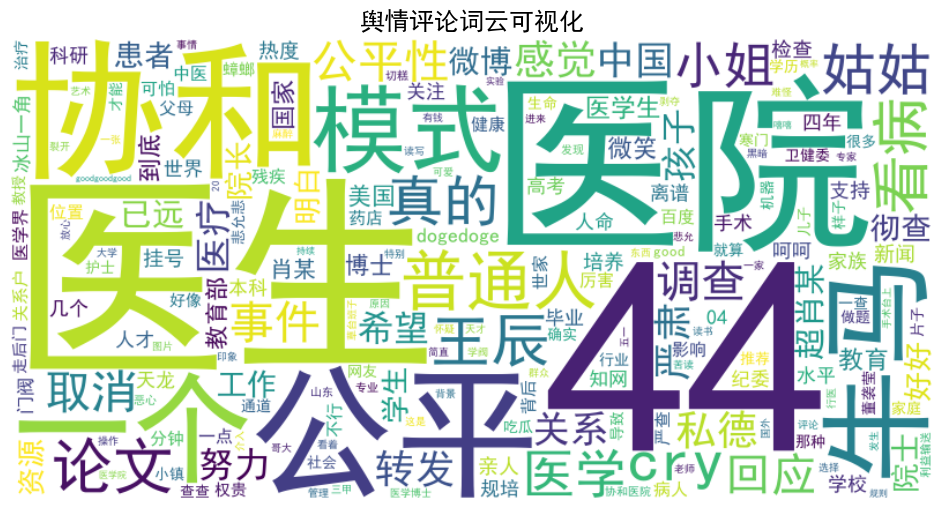

In [22]:

# 1. 读取停用词表
stopwords_path = r"C:\Users\xinyi\Desktop\stopwords-master\baidu_stopwords.txt"
with open(stopwords_path, 'r', encoding='utf-8') as f:
    stopwords = set(line.strip() for line in f if line.strip())

# 2. 分词并过滤停用词，生成tokens列
df['tokens'] = df['clean_text'].apply(lambda x: [word for word in jieba.cut(x) if word not in stopwords and len(word) > 1])

# 3. 统计所有词频
all_words = [word for tokens in df['tokens'] for word in tokens]
word_freq = Counter(all_words)

# 4. 生成词云
wordcloud = WordCloud(font_path='C:/Windows/Fonts/simhei.ttf',
                      background_color='white',
                      width=800,
                      height=400)
wordcloud.generate_from_frequencies(word_freq)

# 5. 显示词云
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("舆情评论词云可视化",fontsize=18)
plt.show()


### 审核结果整合与badcase提取

- 机器审核流程：根据jieba分词和词云可视化，从中提取出几个高频的舆情关键词，比如<font color=#ff0000>“协和”、“4+4”、“内定”、“董小姐”、“关系户”、“肖飞”</font>等，先做了一个初步的标签归类。机器可以快速处理大量评论数据，机器审核通过关键词识别具攻击性、煽动性内容，进行初步判定；

- 人工审核策略：设置舆情专包，聚焦在相关事件中热度高、情绪激烈、质疑协和公信力、造谣性、煽动性的评论上，进行人工复审；

- badcase样本提取：1、从审核判定中提取典型违规样本，做进一步标签沉淀；
2、对人机审核认定不一致或争议大的评论，进行进一步结构化标注（涉及关键词、变体词、情绪风险等级），优化并输出样本库。

## Step 2: 模拟敏感词库 + 命中分析

>&emsp;&emsp;因为缺少机器审核数据，这里我模拟机器审核结果中的违规评论包含高敏词<font color=#ff0000>“录取黑幕”， “医疗腐败” ， “学术垄断” ， “关系户” ， “学阀” ，“门阀” </font>。
其次我发现评论区里出现了大量带有性别歧视倾向的内容，比如说<font color=#ff0000>“靠身体”、“整容女”、“美女博士都是xx”、“卖的”</font>这种对于高学历高颜值女性群体的恶意猜测以及影射性指控，已经不再是就事论事，而是演变为对女性学术群体的规模性污名化。

>&emsp;&emsp;所以我又设计了一个 **“性别攻击识别模块”** ，核心措施包括：
<br>&emsp;&emsp;1、扩充性别攻击高敏词库；
<br>&emsp;&emsp;2、识别语义攻击结构：像<font color=#ff0000>“美女+导师/博士+攻击词”</font>这类语义模式，做二次舆情扩散识别预判。

In [23]:
# 模拟敏感词库（高敏 / 性别攻击）
high_sensitive_words = ['录取黑幕', '医疗腐败', '学术垄断', '关系户', '学阀' ,'门阀']
gender_attack_words = ['靠身体','整容女','美女博士','卖']

# 命中判断
def match_sensitive(text, word_list):
    return any(word in text for word in word_list)

df['高敏命中'] = df['clean_text'].apply(lambda x: match_sensitive(x, high_sensitive_words))
df['性别攻击'] = df['clean_text'].apply(lambda x: match_sensitive(x, gender_attack_words))

df[['clean_text', '高敏命中', '性别攻击']].head(20)

,clean_text,高敏命中,性别攻击
0,关于米氏家族又有新的内情出现,False,False
1,卫健委调查肖某董某同时肖某董某莹应被剥夺行医资格,False,False
2,网友曝出来的协和进行44培训招生的学校名单和8个学生,False,False
3,理性分析大家感觉董小姐是个例还是群像,False,False
4,各种内幕门阀林立普通人太难了允悲,True,False
5,这瓜还会继续的会不会有其他更劲爆的,False,False
6,被关系户插队占了好工作这么多年的书读了反而亏,True,False
7,撕开了这些顶级医院的遮羞布其实都是草台班子,False,False
8,放心吧对他们的影响最多是有点丢脸但是这些人总能想到别的办法过段时间处分一些无关轻重的人下几张...,False,False
9,这种美女博士一查一个草包,False,True


## Step 3: 情绪分析：正负倾向判断

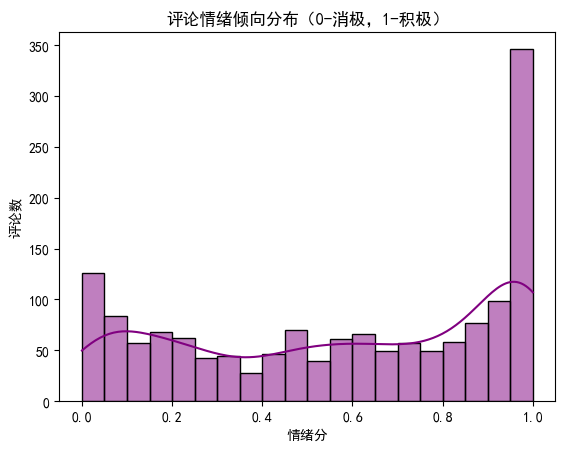

In [12]:
df['情绪分'] = df['clean_text'].apply(lambda x: SnowNLP(x).sentiments)
sns.histplot(df['情绪分'], bins=20, kde=True, color='purple')
plt.title("评论情绪倾向分布（0-消极，1-积极）")
plt.xlabel("情绪分")
plt.ylabel("评论数")
plt.show()

## Step 4: 舆情风险命中情况统计

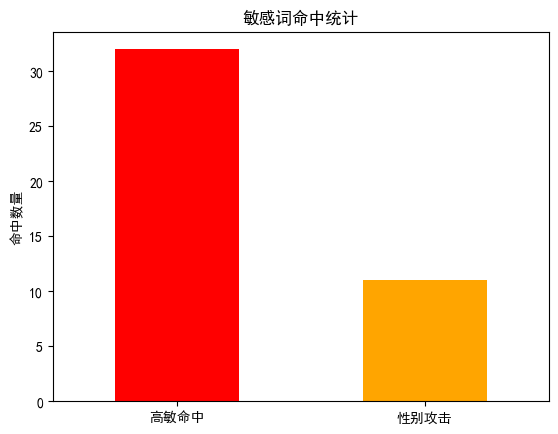

In [13]:
risk_stats = df[['高敏命中', '性别攻击']].sum()
risk_stats.plot(kind='bar', color=['red', 'orange'])
plt.title("敏感词命中统计")
plt.ylabel("命中数量")
plt.xticks(rotation=0)
plt.show()

## Step 4:识别语义攻击结构

In [24]:

# ====== 结构性性别攻击识别模块 ======

# 定义关键词词库
tag_words = ["美女", "女的", "整容女"]
identity_words = ["博士", "导师", "研究生"]
attack_words = ["靠身体", "草包", "上位", "裙带", "潜规则", "走后门","性"]

def match_abc_patterns(text):
    seg = jieba.lcut(text)
    has_a = any(t in seg for t in tag_words)
    has_b = any(i in seg for i in identity_words)
    has_c = any(a in seg for a in attack_words)

    # 命中任意结构就返回 True
    return (has_a and has_c) or (has_b and has_c) or (has_a and has_b and has_c)
  

# 应用于评论数据
df['has_structured_attack'] = df['clean_text'].apply(match_flexible)

# 查看命中评论
structured_attacks = df[df['has_structured_attack']]
print(f"结构性攻击评论数量：{len(structured_attacks)}")
structured_attacks[['clean_text']].head(10)

结构性攻击评论数量：41


,clean_text
9,这种美女博士一查一个草包
39,要是全都是些草包普通人就更难了幸亏有你们毕竟特权是少数普通人才是大多数
128,即使是医学这么严谨的学科都有门阀送走后门的人进来人命关天的大事也可以让这种水平的人上手术台真...
144,我真是怀疑她的父母也是走后门到这个位置的这种权利干涉是她们家代代相传的吧
193,走后门人家都有专用通道的
237,明白了44就是某些人走后门的专用通道
238,帝都的瓜魔都的走后门doge
240,董院士走后门
245,时间给了病人耽误了自己8年本硕3年博士终究抵不过一个好家庭一张好面庞允悲
276,江西万安95后中专副科是下层路线那这是高端局牛马也有打螺丝的也有博士手术刀牛马


# 舆情风控总结与应对策略

1. **高频高敏词监控**：实时抓取关键词云变化，优先处理<font color=#ff0000>“录取黑幕”， “医疗腐败” ， “学术垄断” ， “关系户” ， “学阀” ，“门阀” </font>等高风险词。
2. **公众情绪预警**：设定情绪倾向均值阈值，当情绪分值 < 0.3，优先人工审核，这类言论情绪激烈，容易攻击医护群体或传播谣言，集中注意负面情绪集中爆发窗口期。
3. **二次舆情扩散识别（如性别攻击言论）**：设定针对女性的攻击性言论词库，匹配命中并提交机器人工审核复核。
4. **badcase回收机制**：结合机器策略与人工标注，更新词库与模型识别逻辑。
5. **全链路闭环机制**：舆情预警 → 高频词提取 → 人工+机器协同审核 → 二次舆情扩散识别 → 高敏词维护 → 风控策略沉淀 ，构建舆情风控自动化闭环。